


This sample show how to train end to end pipeline using Vienna python SDK and pytorch.

Training is performed on GPU based DSVM, and inference through Azure container instance

Feel free to swap training compute as the MNIST dataset is used, you can run on CPU with reasonable performance

In [5]:
import os
import json
import time
import shutil
import numpy as np



import azureml.core
from azureml.core.workspace import Workspace
from azureml.core.project import Project
from azureml.core.run import Run
from azureml.core.model import Model
from azureml.core.image import Image
from azureml.core.webservice import AciWebservice, Webservice
from azureml.exceptions.azureml_exception import UserErrorException
from azureml.core.compute_target import RemoteTarget
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies
from azureml.contrib.widgets import RunDetails
import helpers

import torch
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2
print("AML SDK version :",azureml.core.VERSION)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
AML SDK version : 0.1.0.1095338


Modify variables accordingly except for **location** until GA

In [31]:
subscription_id = ""
resource_group = ""
workspace_name = ""
location = 'eastus2'

project_folder = 'c'
project_name = "mnist_cnn"
history_name = project_name + '_history'

dockerrun = False

In [32]:
ws = Workspace.get_or_create(name = workspace_name,
                      subscription_id = subscription_id,
                      resource_group = resource_group, 
                      location = location)
project = Project.attach(ws, history_name, project_folder)


project_folder = project.project_directory
print("workspace name:",ws.name)
print("project directory: ", project.project_directory)
print("project history: ", project.history.name)

workspace name: vnext_workspace
project directory:  c:\sources\vienna_samples\mnist-cnn
project history:  mnist_cnn_history


In [33]:
%%writefile $project_folder/network.py

import os 
from azureml.core.run import Run
import torch
import torch.nn as nn
import torch.nn.functional as F


##### network definition input->conv->maxpool->conv->maxpool->fc->softmax

class ConvNet(torch.nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()
        
        kernel_shape=(2, 2)
        stride=(2, 2)
        padding=0
        self.fc_neurons = 392
        num_labels = 10
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4,
                               kernel_size=(3, 3),stride=(1, 1),
                               padding=1)
        self.pool1 = nn.MaxPool2d(kernel_shape,stride, padding)
        
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=8,
                               kernel_size=(3, 3),stride=(1, 1),
                               padding=1)
        self.pool2 = nn.MaxPool2d(kernel_shape,stride, padding)
        
        self.fc1 = nn.Linear(self.fc_neurons, num_labels)
        
    def forward(self, X):
        out = F.relu(self.pool1(self.conv1(X)))
        out = F.relu(self.pool2(self.conv2(out)))
        
        out = out.view(-1, self.fc_neurons)
        y_pred = self.fc1(out)
        
        return y_pred 
        
    
##### end of network definition

Writing c:\sources\vienna_samples\mnist-cnn/network.py


In [34]:
%%writefile $project_folder/train.py

import os 
import shutil

from azureml.core.run import Run
from azureml.core.model import Model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from network import ConvNet


class learner():
    
    def __init__(self, train_data, run):
        batch_size = 32
        self.num_epochs = 10
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        num_gpus = torch.cuda.device_count()
        print('Training on {} \nFound {} CUDA Devices'\
                  .format(self.device, num_gpus))
        
        ''' breaks inference on ACI for now
        if num_gpus > 1: 
            self.model = nn.DataParallel(self.model)'''

        self.loader = DataLoader(dataset=train_data, 
                                  batch_size=batch_size, 
                                  shuffle=True)
        
        
        self.model = ConvNet().to(self.device)
        print(self.model)
        
        self.criterion = nn.CrossEntropyLoss().to(self.device)  
        self.optimizer = Adam(self.model.parameters(), lr=1e-5)
        
        self.run = run 
    
    def train(self):
        model = self.model.train()
        for epoch in range(self.num_epochs):
            for batch_idx, (X, y) in enumerate(self.loader):
                X = X.to(self.device)
                y = y.to(self.device)
                
                y_pred = model(X)
                
                loss = self.criterion(y_pred, y)
                self.optimizer.zero_grad()
                loss.backward() 
                self.optimizer.step()
                
                _, argmax = torch.max(y_pred, 1)
                accuracy = (y == argmax.squeeze()).float().mean()
                
                if not batch_idx % 1000:
                    
                    self.run.log("loss", loss.item())
                    self.run.log("accuracy", accuracy.item())
                    print ('epoch [{}/{}], loss: {:.4f}, accuracy: {:.2f}' 
                           .format(epoch+1, self.num_epochs, loss.item(), accuracy.item()))
            
        return model
            

    
def train_network():
    torch.manual_seed(123)
    print("Pytorch version", torch.__version__)
    
    train_directory = 'mnist_dataset'
    model_path = 'mnist_model.pth'
    model_name = 'mnist-model'
    
    mnist_mean = 0.1307
    mnist_std = 0.3081
    
    do_download = False 
    
    if not os.path.isdir(train_directory):
        os.mkdir(train_directory)
        do_download = True
        
        
    train_dataset = datasets.MNIST(root= train_directory,train=True, 
                               transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((mnist_mean,), (mnist_std,))
                               ]),download=do_download)
    
    run =  Run.get_submitted_run()
    
    network = learner(train_dataset, run)
    model = network.train()
    
    print("Model saved to", model_path)
    torch.save(model.state_dict(), model_path)
    
    run.upload_file(name = "outputs/" + model_path,
                    path_or_stream = model_path)
    model = run.register_model(model_name = model_name,
                       model_path = "outputs/" + model_path)
    print("Model registered as :" ,model.id)
    
    try:
        shutil.rmtree(train_directory)
    except OSError as e:
        print ("Error: %s." % (e.strerror))

train_network()

Writing c:\sources\vienna_samples\mnist-cnn/train.py


<br>
## Attach DSVM compute to project


Modify your Azure DSVM information accordingly

In [35]:
dsvm_compute = RemoteTarget(name = "gpu-dsvm", 
                            address = "192.168.1.28:22", 
                            username = "user", 
                            password = "xxxx")
try:
    # Attaches a DSVM as a compute target.
    project.attach_legacy_compute_target(dsvm_compute)
except UserErrorException as e:
    print("Caught = {}".format(e.message))
    print("Compute config already attached.")

<br>
## Configure run on DSVM


If run is executed on DSVM environment, make sure dependecies are installed in the environment

In [36]:
run_config = RunConfiguration.load(project_object = project, run_config_name =  "gpu-dsvm")

if not dockerrun:
    
    print("Configuring local run on remote compute...")
    run_config.environment.python.interpreter_path = '/anaconda/envs/py35/bin/python'
    run_config.environment.python.user_managed_dependencies = True
else:
    
    print("Configuring docker  run on remote compute...")
    run_config.environment.docker.enabled = True
    run_config.environment.docker.base_image = "pytorch/pytorch:0.4_cuda9_cudnn7"
    print('Base Docker image is:', run_config.environment.docker.base_image )

    # Ask system to provision a new one based on the conda_dependencies.yml file
    run_config.environment.python.user_managed_dependencies = False
    run_config.prepare_environment = True

    # create a new CondaDependencies obj
    cd = CondaDependencies()

    # add pytorch as a conda dependency
    cd.add_channel('pytorch')
    cd.add_conda_package('pytorch')
    cd.add_conda_package('torchvision')

    cd.save_to_file(project_dir = project_folder, file_name='conda_dependencies.yml')


Configuring local run on remote compute...


## Train model

In [37]:
%%time 
run = Run.submit(project_object = project,
                 run_config = run_config,
                 script_to_run = 'train.py')

run.wait_for_completion(show_output = False)
RunDetails(run).show()

UserRun()

Wall time: 3min 48s




# Operationalize model

This is done in 2 steps:

- Images preparation
- Deploy image to ACI for serving





## Image preparation

We carried this through:

- creation of score script
- creation of YML file to include required packages for image creation

In [60]:
%%writefile $project_folder/score.py

import os
import sys
import json
import numpy as np
import torch
import torch.nn as nn
from network import ConvNet

from azureml.core.model import Model
from azureml.core.run import Run


sys.path.append(os.path.dirname(__file__))

def init():
    
    global model
    
    model_name = 'mnist-model'
    version = 1
    model_path = Model.get_model_path(model_name = model_name)
    print("model loaded from ",model_path)
    model = ConvNet()
    model.load_state_dict(torch.load(model_path, map_location='cpu'))


def run(image):
    try:
        data = json.loads(image)['image']
        data = torch.from_numpy(np.array(data)).type(torch.FloatTensor)
        data = data.unsqueeze(0)
        
        result = model(data)
        _, y_pred = torch.max(result, dim = 1)
        
        return json.dumps({"predicted": y_pred.numpy().tolist()})
    except Exception as e:
        result = str(e)
        return json.dumps({"error": result})

Overwriting c:\sources\vienna_samples\mnist-cnn/score.py


In [61]:
%%writefile $project_folder/pytorch-env.yml
name: pytorch-env
channels:
  - pytorch
  - conda-forge


dependencies:
  - python=3.5.2
  - pytorch==0.4.0
  - torchvision
  - cuda90 
  
  - pip:
    - --index-url https://azuremlsdktestpypi.azureedge.net/sdk-release/Preview/E7501C02541B433786111FE8E140CAA1
    - --extra-index-url https://pypi.python.org/simple
    - azureml-defaults
    - scikit-learn>=0.19.1

Overwriting c:\sources\vienna_samples\mnist-cnn/pytorch-env.yml




## Deploy Webservice to ACI

This will take a while....

In [62]:
%%time
aci_config = AciWebservice.deploy_configuration(cpu_cores = 2, 
                                               memory_gb = 4, 
                                               tags = ['demo'], 
                                               description = 'Vienna ACI')

models = ws.models('mnist-model')
model = max(models, key = lambda model: model.version) if len(models) > 1 else models[0]
print(model.id, model.created_time, model.url)       

#prod end point torched
aci_service_name = 'torched6'
aci_service = Webservice.deploy_from_model(deployment_config = aci_config,
                                           models = [model],
                                           name = aci_service_name,
                                           workspace = ws,
                                           execution_script = 'score.py',
                                           conda_file = "pytorch-env.yml",
                                           dependencies=['network.py'],
                                           runtime ="python")
aci_service.wait_for_deployment(True)
print(aci_service.state)

mnist-model:16 2018-07-12 07:39:51.256216+00:00 aml://asset/49b97a2026e441ebb4b279e0147401cd
Creating image
Image creation operation finished for image torched6:1, operation "Succeeded"
Creating service
Running...............................................................................................................
TimedOutACI service creation operation finished, operation "TimedOut"
Transitioning
Wall time: 23min 8s


## Prepare test dataset for inference

In [41]:
test_directory = "test_images"

do_download = False
if not os.path.isdir(test_directory):
    os.mkdir(test_directory)
    do_download = True
    

mnist_mean = 0.1307
mnist_std = 0.3081
mnist_test = datasets.MNIST(root=test_directory,train=False, 
                               transform=transforms.Compose([
                                           transforms.ToTensor(),
                                           transforms.Normalize((mnist_mean,), (mnist_std,))]),
                               download=do_download)

num_indices = 24
indices = np.random.randint(0,mnist_test.test_data.shape[0],num_indices)
images_loader = DataLoader(mnist_test,batch_size=num_indices,
                          sampler=SubsetRandomSampler(indices))



def imshow(img):
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0))) # channel last

False
Processing...
Done!


## Run inference on model

Healthy
End point: torched6, serving on http://40.121.36.5:5001/score


predicted [[9], [6], [1], [9], [9], [2], [3], [3], [5], [3], [3], [0], [0], [9], [7], [1], [9], [8], [1], [2], [6], [3], [1], [2]]


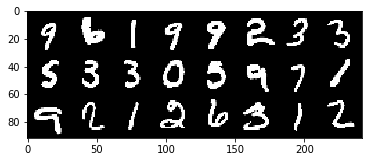

In [66]:
'''
     for now we get new reference to ACI due to transient timeout 
    deploy_from_model return aci reference with corrupted state
 
 '''

print(aci_service.state)
if aci_service is not 'Healthy':
    aci_service = AciWebservice(name=aci_service_name,workspace=ws)
    
print('End point: {}, serving on {}' 
        .format(aci_service_name, aci_service.scoring_uri))
      

predictions = []
images_iter = iter(images_loader)
images,_ = images_iter.next()

for test_img in images:
    np_img = test_img.numpy()
    test_input = json.dumps({'image':np_img.tolist()})
    output = json.loads(aci_service.run(test_input))
    predictions.append(output['predicted'])
    
    
print("predicted", predictions)
imshow(utils.make_grid(images))

## Clean up

In [67]:
if aci_service:
    aci_service.delete()

try:
    shutil.rmtree(test_directory)
except OSError as e:
    print ("Error: %s." % (e.strerror))